In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import randint

# prep
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score

#Neural Network
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Naive bayes
from sklearn.naive_bayes import GaussianNB

#Stacking
from mlxtend.classifier import StackingClassifier

In [2]:
df = pd.read_csv('mental_health_finaldata_1.csv')

In [3]:
train_df = pd.read_csv('mental_health_finaldata_1.csv')
print(train_df.shape)
print(train_df.describe())
print(train_df.info())

(799, 13)
             Age     Sex Occupation Days_Indoors Growing_Stress  \
count        799     799        799          799            799   
unique         4       2          5            5              3   
top     30-Above  Female  Housewife   31-60 days            Yes   
freq         217     425        182          168            292   

       Quarantine_Frustrations Changes_Habits Mental_Health_History  \
count                      799            799                   799   
unique                       3              3                     3   
top                        Yes            Yes                 Maybe   
freq                       298            302                   276   

       Weight_Change Mood_Swings Coping_Struggles Work_Interest  \
count            799         799              799           799   
unique             3           3                2             3   
top            Maybe         Low               No            No   
freq             271         2

In [4]:
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

                         Total  Percent
Age                          0      0.0
Sex                          0      0.0
Occupation                   0      0.0
Days_Indoors                 0      0.0
Growing_Stress               0      0.0
Quarantine_Frustrations      0      0.0
Changes_Habits               0      0.0
Mental_Health_History        0      0.0
Weight_Change                0      0.0
Mood_Swings                  0      0.0
Coping_Struggles             0      0.0
Work_Interest                0      0.0
Social_Weakness              0      0.0


In [5]:
#dealing with missing data

train_df.isnull().sum().max() #just checking that there's no missing data missing...
train_df.head(5)

,Age,Sex,Occupation,Days_Indoors,Growing_Stress,Quarantine_Frustrations,Changes_Habits,Mental_Health_History,Weight_Change,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness
0,20-25,Female,Corporate,1-14 days,Yes,Yes,No,Yes,Yes,Medium,No,No,Yes
1,30-Above,Male,Others,31-60 days,Yes,Yes,Maybe,No,No,High,No,No,Yes
2,30-Above,Female,Student,Go out Every day,No,No,Yes,No,No,Medium,Yes,Maybe,No
3,25-30,Male,Others,1-14 days,Yes,No,Maybe,No,Maybe,Medium,No,Maybe,Yes
4,16-20,Female,Student,More than 2 months,Yes,Yes,Yes,No,Yes,Medium,Yes,Maybe,No


In [6]:
# Assign default values for each data type
defaultInt = 0
defaultString = 'NaN'
defaultFloat = 0.0

# Create lists by data tpe
intFeatures = ['Age']
stringFeatures = ['Sex', 'Occupation', 'Days_Indoors', 'Growing_Stress', 'Quarantine_Frustrations', 'Changes_Habits',
                 'Mental_Health_History', 'Weight_Change', 'Mood_Swings', 'Coping_Struggles', 'Work_Interest', 'Social_Weakness']
floatFeatures = []

# Clean the NaN's
for feature in train_df:
    if feature in intFeatures:
        train_df[feature] = train_df[feature].fillna(defaultInt)
    elif feature in stringFeatures:
        train_df[feature] = train_df[feature].fillna(defaultString)
    elif feature in floatFeatures:
        train_df[feature] = train_df[feature].fillna(defaultFloat)
    else:
        print('Error: Feature %s not recognized.' % feature)
train_df.head()

,Age,Sex,Occupation,Days_Indoors,Growing_Stress,Quarantine_Frustrations,Changes_Habits,Mental_Health_History,Weight_Change,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness
0,20-25,Female,Corporate,1-14 days,Yes,Yes,No,Yes,Yes,Medium,No,No,Yes
1,30-Above,Male,Others,31-60 days,Yes,Yes,Maybe,No,No,High,No,No,Yes
2,30-Above,Female,Student,Go out Every day,No,No,Yes,No,No,Medium,Yes,Maybe,No
3,25-30,Male,Others,1-14 days,Yes,No,Maybe,No,Maybe,Medium,No,Maybe,Yes
4,16-20,Female,Student,More than 2 months,Yes,Yes,Yes,No,Yes,Medium,Yes,Maybe,No


In [7]:
#Clean 'Gender'
Sex = train_df['Sex'].unique()
print(Sex)

['Female' 'Male']


In [8]:
#Made gender groups
male_str = ["Male"]
female_str = ["Female "]

for (row, col) in train_df.iterrows():

    if str.lower(col.Sex) in male_str:
        train_df['Sex'].replace(to_replace=col.Sex, value='male', inplace=True)

    if str.lower(col.Sex) in female_str:
        train_df['Sex'].replace(to_replace=col.Sex, value='female', inplace=True)

#Get rid of bullshit
stk_list = ['A little about you', 'p']
train_df = train_df[~train_df['Sex'].isin(stk_list)]

print(train_df['Sex'].unique())

['Female' 'Male']


In [9]:
#Encoding data
labelDict = {}
for feature in train_df:
    le = preprocessing.LabelEncoder()
    le.fit(train_df[feature])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df[feature] = le.transform(train_df[feature])
    # Get labels
    labelKey = 'label_' + feature
    labelValue = [*le_name_mapping]
    labelDict[labelKey] =labelValue

for key, value in labelDict.items():
    print(key, value)

label_Age ['16-20', '20-25', '25-30', '30-Above']
label_Sex ['Female', 'Male']
label_Occupation ['Business', 'Corporate', 'Housewife', 'Others', 'Student']
label_Days_Indoors ['1-14 days', '15-30 days', '31-60 days', 'Go out Every day', 'More than 2 months']
label_Growing_Stress ['Maybe', 'No', 'Yes']
label_Quarantine_Frustrations ['Maybe', 'No', 'Yes']
label_Changes_Habits ['Maybe', 'No', 'Yes']
label_Mental_Health_History ['Maybe', 'No', 'Yes']
label_Weight_Change ['Maybe', 'No', 'Yes']
label_Mood_Swings ['High', 'Low', 'Medium']
label_Coping_Struggles ['No', 'Yes']
label_Work_Interest ['Maybe', 'No', 'Yes']
label_Social_Weakness ['Maybe', 'No', 'Yes']


In [10]:
#missing data
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

                         Total  Percent
Age                          0      0.0
Sex                          0      0.0
Occupation                   0      0.0
Days_Indoors                 0      0.0
Growing_Stress               0      0.0
Quarantine_Frustrations      0      0.0
Changes_Habits               0      0.0
Mental_Health_History        0      0.0
Weight_Change                0      0.0
Mood_Swings                  0      0.0
Coping_Struggles             0      0.0
Work_Interest                0      0.0
Social_Weakness              0      0.0


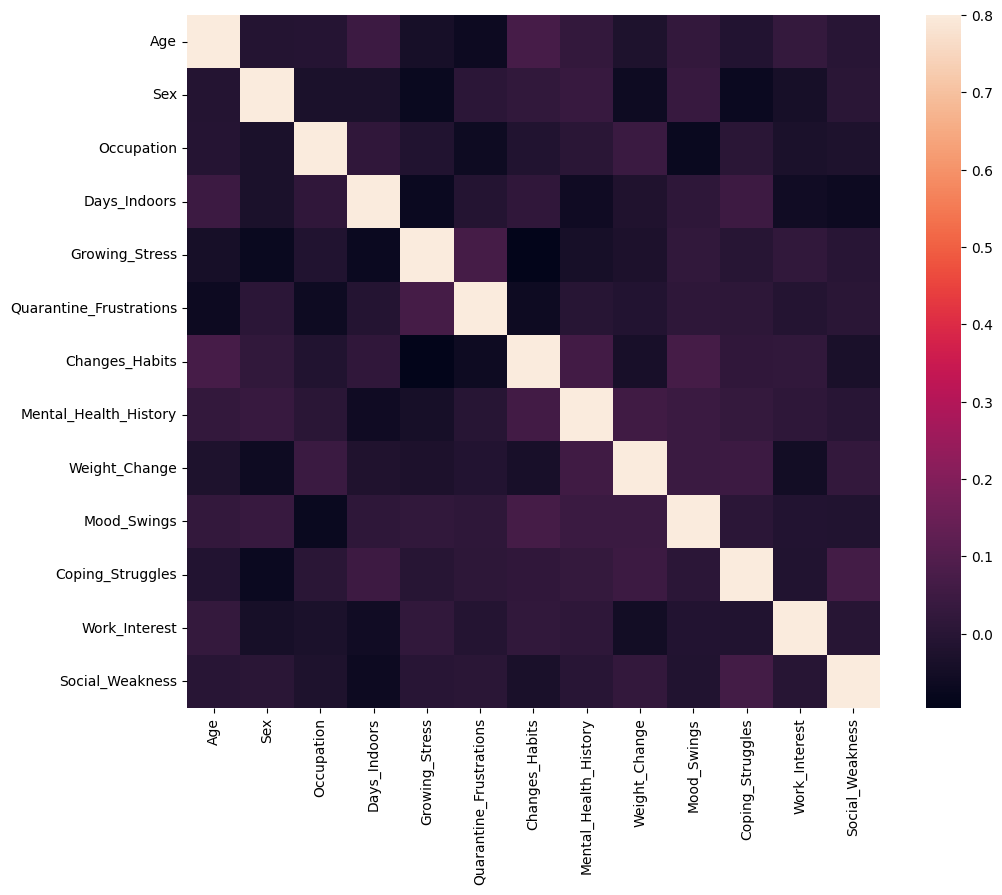

In [11]:
#correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

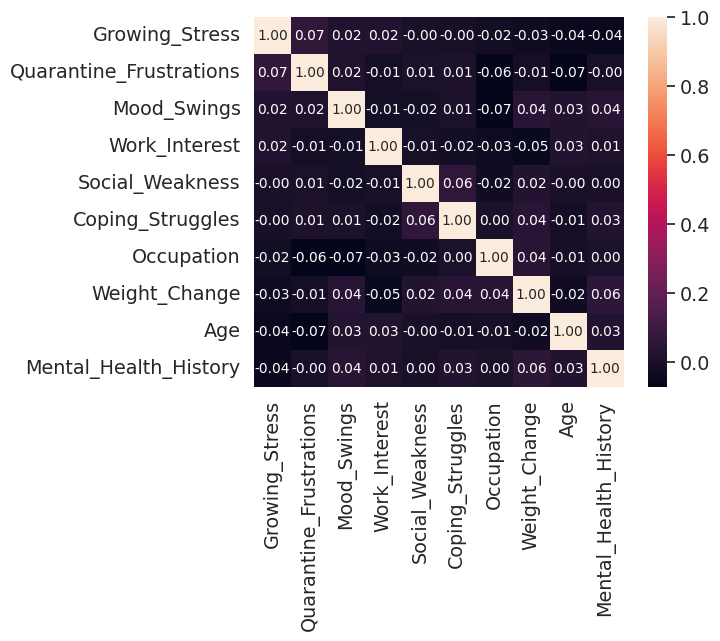

In [12]:
#treatment correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Growing_Stress')['Growing_Stress'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [13]:
# Scaling Age
scaler = MinMaxScaler()
train_df['Age'] = scaler.fit_transform(train_df[['Age']])
train_df.head()

,Age,Sex,Occupation,Days_Indoors,Growing_Stress,Quarantine_Frustrations,Changes_Habits,Mental_Health_History,Weight_Change,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness
0,0.333333,0,1,0,2,2,1,2,2,2,0,1,2
1,1.000000,1,3,2,2,2,0,1,1,0,0,1,2
2,1.000000,0,4,3,1,1,2,1,1,2,1,0,1
3,0.666667,1,3,0,2,1,0,1,0,2,0,0,2
4,0.000000,0,4,4,2,2,2,1,2,2,1,0,1


In [14]:
# define X and y
feature_cols = ['Age', 'Sex', 'Occupation', 'Days_Indoors', 'Growing_Stress', 'Quarantine_Frustrations', 'Changes_Habits',
                 'Mental_Health_History', 'Weight_Change', 'Mood_Swings', 'Coping_Struggles', 'Work_Interest', 'Social_Weakness']
X = train_df[feature_cols]
y = train_df['Growing_Stress']

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Create dictionaries for final graph
# Use: methodDict['Stacking'] = accuracy_score
methodDict = {}
rmseDict = ()

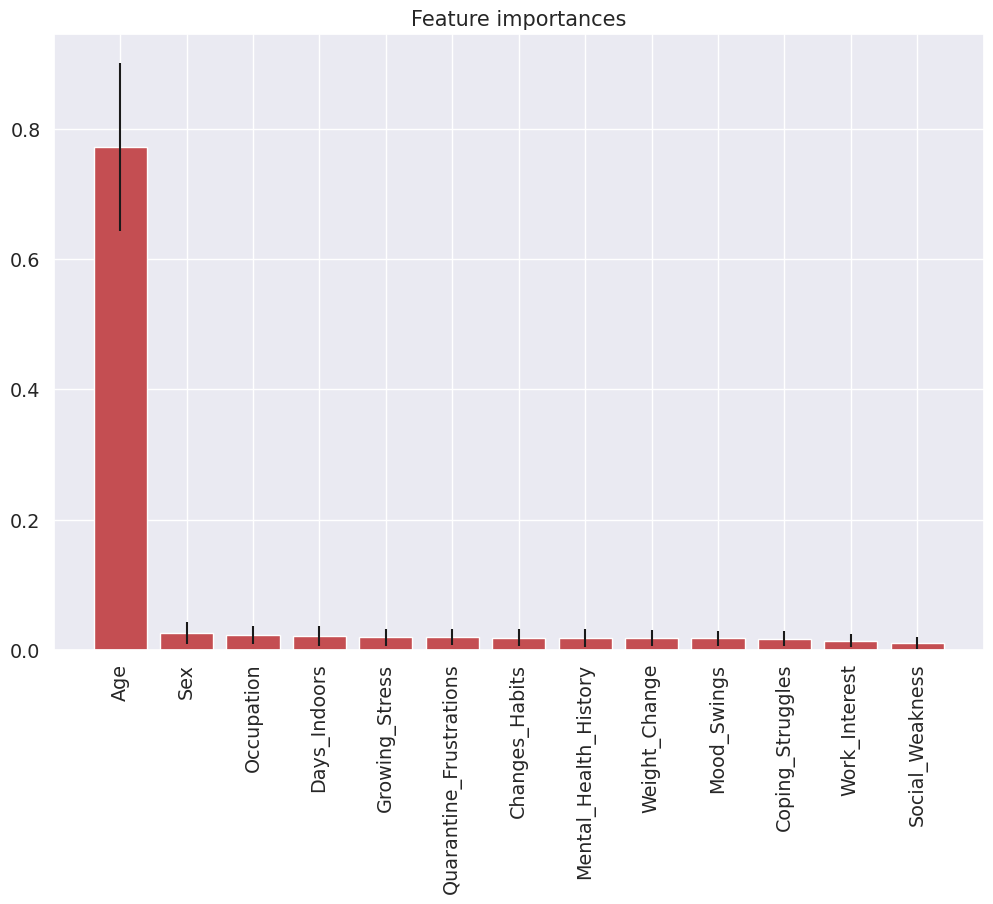

In [15]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

labels = []
for f in range(X.shape[1]):
    labels.append(feature_cols[f])

# Plot the feature importances of the forest
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

In [16]:
def evalClassModel(model, y_test, y_pred_class, plot=False):
    #Classification accuracy: percentage of correct predictions
    # calculate accuracy
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class))

    #Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # examine the class distribution of the testing set (using a Pandas Series method)
    print('Null accuracy:\n', y_test.value_counts())

    # calculate the percentage of ones
    print('Percentage of ones:', y_test.mean())

    # calculate the percentage of zeros
    print('Percentage of zeros:',1 - y_test.mean())

    #Comparing the true and predicted response values
    print('True:', y_test.values[0:25])
    print('Pred:', y_pred_class[0:25])

    #Confusion matrix
    # save confusion matrix and slice into four pieces
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    # visualize Confusion Matrix
    sns.heatmap(confusion,annot=True,fmt="d")
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    #Metrics computed from a confusion matrix
    #Classification Accuracy: Overall, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    print('Classification Accuracy:', accuracy)

    #Classification Error: Overall, how often is the classifier incorrect?
    print('Classification Error:', 1 - metrics.accuracy_score(y_test, y_pred_class))

    #False Positive Rate: When the actual value is negative, how often is the prediction incorrect?
    false_positive_rate = FP / float(TN + FP)
    print('False Positive Rate:', false_positive_rate)

    #Precision: When a positive value is predicted, how often is the prediction correct?
    print('Precision:', metrics.precision_score(y_test, y_pred_class))


    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    print('AUC Score:', metrics.roc_auc_score(y_test, y_pred_class))

    # calculate cross-validated AUC
    print('Cross-validated AUC:', cross_val_score(model, X, y, cv=10, scoring='roc_auc').mean())

    ##########################################
    #Adjusting the classification threshold
    ##########################################
    # print the first 10 predicted responses
    print('First 10 predicted responses:\n', model.predict(X_test)[0:10])

    # print the first 10 predicted probabilities of class membership
    print('First 10 predicted probabilities of class members:\n', model.predict_proba(X_test)[0:10])

    # print the first 10 predicted probabilities for class 1
    model.predict_proba(X_test)[0:10, 1]

    # store the predicted probabilities for class 1
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    if plot == True:
        # histogram of predicted probabilities
        plt.rcParams['font.size'] = 12
        plt.hist(y_pred_prob, bins=8)

        # x-axis limit from 0 to 1
        plt.xlim(0,1)
        plt.title('Histogram of predicted probabilities')
        plt.xlabel('Predicted probability of treatment')
        plt.ylabel('Frequency')


    # predict treatment if the predicted probability is greater than 0.3
    # it will return 1 for all values above 0.3 and 0 otherwise
    # results are 2D so we slice out the first column
    y_pred_prob = y_pred_prob.reshape(-1,1)
    y_pred_class = binarize(y_pred_prob, 0.3)[0]

    # print the first 10 predicted probabilities
    print('First 10 predicted probabilities:\n', y_pred_prob[0:10])

    ##########################################
    #ROC Curves and Area Under the Curve (AUC)
    ##########################################

    #AUC is the percentage of the ROC plot that is underneath the curve
    #Higher value = better classifier
    roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)



    # IMPORTANT: first argument is true values, second argument is predicted probabilities
    # roc_curve returns 3 objects fpr, tpr, thresholds
    # fpr: false positive rate
    # tpr: true positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    if plot == True:
        plt.figure()

        plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for treatment classifier')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.show()

    # define a function that accepts a threshold and prints sensitivity and specificity
    def evaluate_threshold(threshold):
        #Sensitivity: When the actual value is positive, how often is the prediction correct?
        #Specificity: When the actual value is negative, how often is the prediction correct?print('Sensitivity for ' + str(threshold) + ' :', tpr[thresholds > threshold][-1])
        print('Specificity for ' + str(threshold) + ' :', 1 - fpr[thresholds > threshold][-1])

    # One way of setting threshold
    predict_mine = np.where(y_pred_prob > 0.50, 1, 0)
    confusion = metrics.confusion_matrix(y_test, predict_mine)
    print(confusion)



    return accuracy

In [17]:
def tuningCV(knn):

    # search for an optimal value of K for KNN
    k_range = list(range(1, 31))
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
        k_scores.append(scores.mean())
    print(k_scores)
    # plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()

In [18]:
def tuningGridSerach(knn):
    #More efficient parameter tuning using GridSearchCV
    k_range = list(range(1, 31))
    print(k_range)

    # create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range)
    print(param_grid)

    # instantiate the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')

    # fit the grid with data
    grid.fit(X, y)

    # view the complete results (list of named tuples)
    grid.grid_scores_

    # examine the first tuple
    print(grid.grid_scores_[0].parameters)
    print(grid.grid_scores_[0].cv_validation_scores)
    print(grid.grid_scores_[0].mean_validation_score)

    # create a list of the mean scores only
    grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
    print(grid_mean_scores)

    # plot the results
    plt.plot(k_range, grid_mean_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.show()

    # examine the best model
    print('GridSearch best score', grid.best_score_)
    print('GridSearch best params', grid.best_params_)
    print('GridSearch best estimator', grid.best_estimator_)

In [19]:
def tuningRandomizedSearchCV(model, param_dist):
    #Searching multiple parameters simultaneously
    # n_iter controls the number of searches
    rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
    rand.fit(X, y)
    rand.cv_results_

    # examine the best model
    print('Rand. Best Score: ', rand.best_score_)
    print('Rand. Best Params: ', rand.best_params_)

    # run RandomizedSearchCV 20 times (with n_iter=10) and record the best score
    best_scores = []
    for _ in range(20):
        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10)
        rand.fit(X, y)
        best_scores.append(round(rand.best_score_, 3))
    print(best_scores)

In [20]:
def tuningMultParam(knn):

    #Searching multiple parameters simultaneously
    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']

    # create a parameter grid: map the parameter names to the values that should be searched
    param_grid = dict(n_neighbors=k_range, weights=weight_options)
    print(param_grid)

    # instantiate and fit the grid
    grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
    grid.fit(X, y)

    # view the complete results
    print(grid.grid_scores_)

    # examine the best model
    print('Multiparam. Best Score: ', grid.best_score_)
    print('Multiparam. Best Params: ', grid.best_params_)

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def logisticRegression():
    # train a logistic regression model on the training set
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)

    # make class predictions for the testing set
    y_pred_class = logreg.predict(X_test)

    # Compute accuracy score
    accuracy = accuracy_score(y_test, y_pred_class)
    print("Accuracy:", accuracy)

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_class)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Data for final graph
    methodDict['Log. Regression'] = accuracy * 100


Accuracy: 1.0


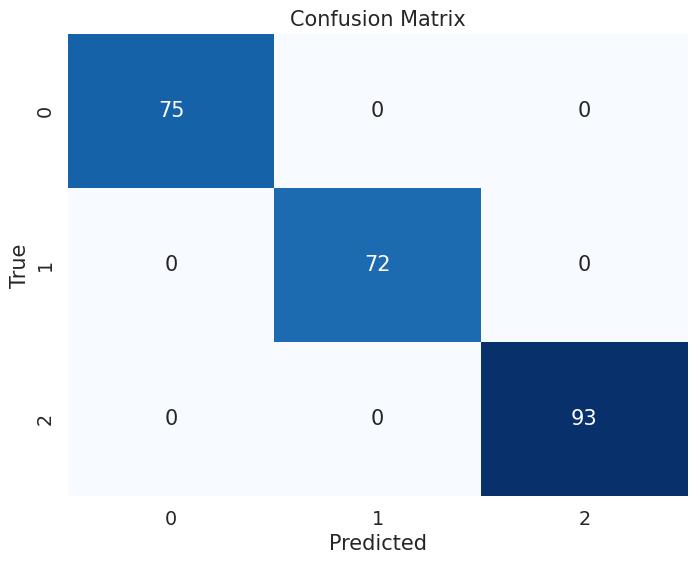

In [22]:
logisticRegression()

In [23]:
import matplotlib.pyplot as plt

def Knn():
    # Calculating the best parameters
    knn = KNeighborsClassifier(n_neighbors=5)

    # define the parameter values that should be searched
    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']

    # specify "parameter distributions" rather than a "parameter grid"
    param_dist = dict(n_neighbors=k_range, weights=weight_options)
    tuningRandomizedSearchCV(knn, param_dist)

    # train a KNeighborsClassifier model on the training set
    knn = KNeighborsClassifier(n_neighbors=22, weights='distance')  # Use the best parameters
    knn.fit(X_train, y_train)

    # make class predictions for the testing set
    y_pred_class = knn.predict(X_test)

    # Compute accuracy score
    accuracy = accuracy_score(y_test, y_pred_class) * 100

    # Data for final graph
    methodDict['K-Neighbors'] = accuracy

    # Collect accuracy values for different values of k
    accuracy_values = []
    for k in range(1, 21):
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        knn.fit(X_train, y_train)
        y_pred_class = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred_class)
        accuracy_values.append(accuracy)

    # Plot the performance graph
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 21), accuracy_values, marker='o', linestyle='-')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Neighbors')
    plt.grid(True)
    plt.show()


Rand. Best Score:  0.8698734177215188
Rand. Best Params:  {'weights': 'distance', 'n_neighbors': 22}
[0.859, 0.87, 0.872, 0.877, 0.867, 0.877, 0.857, 0.85, 0.87, 0.872, 0.856, 0.862, 0.872, 0.87, 0.867, 0.877, 0.877, 0.859, 0.859, 0.877]


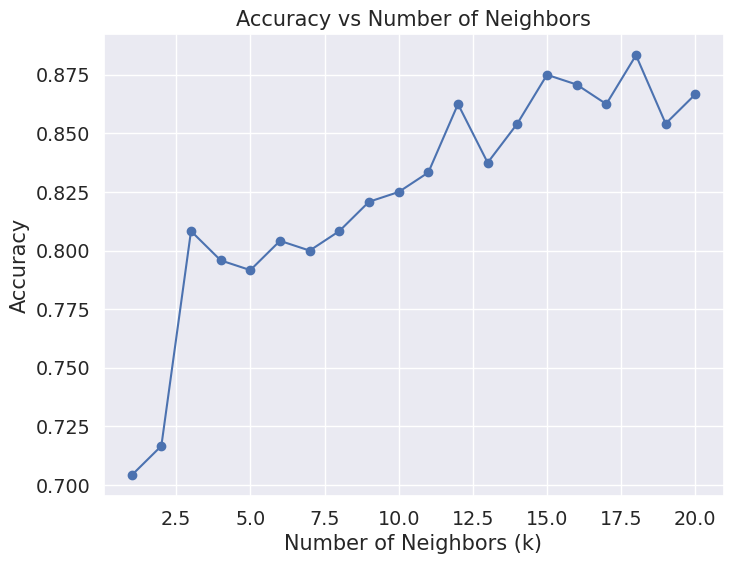

In [24]:
Knn()

In [25]:
import matplotlib.pyplot as plt

def treeClassifier():
    # Calculating the best parameters
    tree = DecisionTreeClassifier()
    featuresSize = feature_cols.__len__()
    param_dist = {"max_depth": [3, None],
                  "max_features": randint(1, featuresSize),
                  "min_samples_split": randint(2, 9),
                  "min_samples_leaf": randint(1, 9),
                  "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(tree, param_dist)

    # train a decision tree model on the training set
    tree = DecisionTreeClassifier(max_depth=3, min_samples_split=8, max_features=6, criterion='entropy', min_samples_leaf=7)
    tree.fit(X_train, y_train)

    # make class predictions for the testing set
    y_pred_class = tree.predict(X_test)

    # Compute accuracy directly
    accuracy = accuracy_score(y_test, y_pred_class)

    # Data for final graph
    methodDict['Decision Tree Classifier'] = accuracy * 100

    # Collect performance metrics for different parameter settings
    depths = [3, None]
    accuracies = []
    for depth in depths:
        tree = DecisionTreeClassifier(max_depth=depth, min_samples_split=8, max_features=6, criterion='entropy', min_samples_leaf=7)
        tree.fit(X_train, y_train)
        y_pred_class = tree.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred_class)
        accuracies.append(accuracy)

    # Plot the performance graph
    plt.figure(figsize=(8, 6))
    plt.plot(depths, accuracies, marker='o', linestyle='-')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Max Depth')
    plt.grid(True)
    plt.show()


Rand. Best Score:  0.99
Rand. Best Params:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 12, 'min_samples_leaf': 2, 'min_samples_split': 8}
[0.997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.991, 1.0, 1.0]


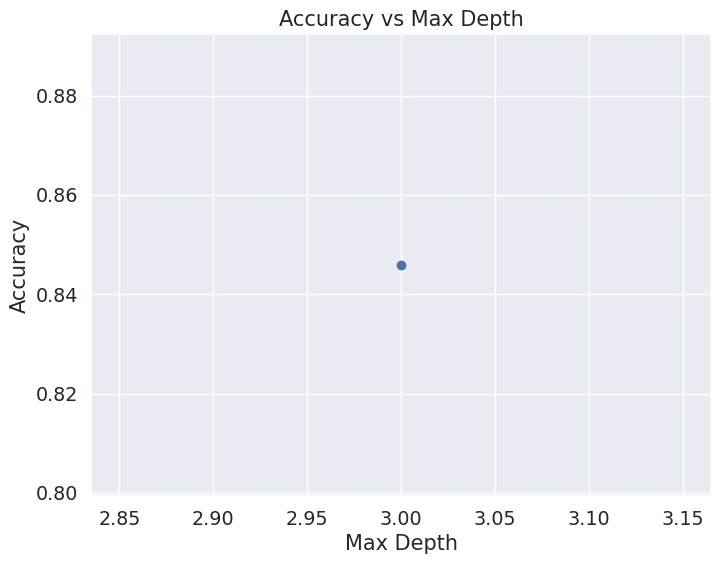

In [26]:
treeClassifier()

In [27]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def randomForest():
    # Calculating the best parameters
    forest = RandomForestClassifier(n_estimators=20)
    featuresSize = len(feature_cols)
    param_dist = {"max_depth": [3, None],
                  "max_features": randint(1, featuresSize),
                  "min_samples_split": randint(2, 9),
                  "min_samples_leaf": randint(1, 9),
                  "criterion": ["gini", "entropy"]}
    tuningRandomizedSearchCV(forest, param_dist)

    # Building and fitting the random forest model
    forest = RandomForestClassifier(max_depth=None, min_samples_leaf=8, min_samples_split=2, n_estimators=20, random_state=1)
    my_forest = forest.fit(X_train, y_train)

    # make class predictions for the testing set
    y_pred_class = my_forest.predict(X_test)

    # Compute accuracy directly
    accuracy = accuracy_score(y_test, y_pred_class)

    # Data for final graph
    methodDict['Random Forest'] = accuracy * 100

    # Collect performance metrics for different parameter settings
    depths = [3, None]
    accuracies = []
    for depth in depths:
        forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=8, min_samples_split=2, n_estimators=20, random_state=1)
        my_forest = forest.fit(X_train, y_train)
        y_pred_class = my_forest.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred_class)
        accuracies.append(accuracy)

    # Plot the performance graph
    plt.figure(figsize=(8, 6))
    plt.plot(depths, accuracies, marker='o', linestyle='-')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Max Depth')
    plt.grid(True)
    plt.show()


Rand. Best Score:  1.0
Rand. Best Params:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 7, 'min_samples_split': 2}
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


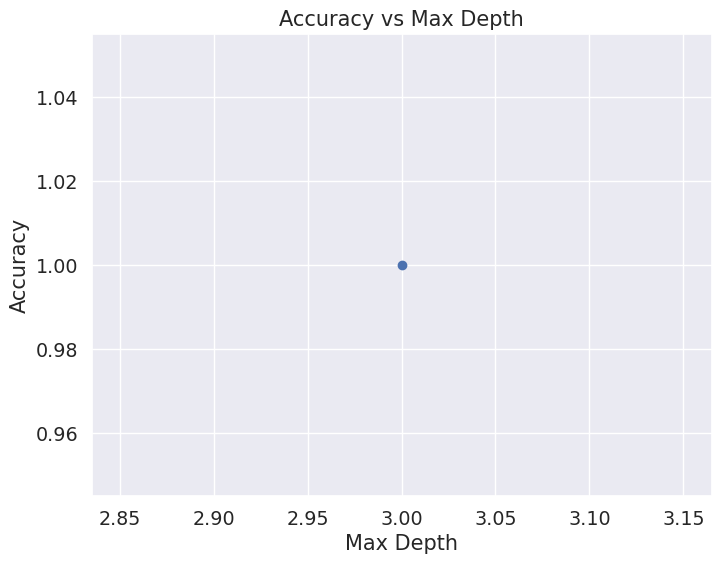

In [28]:
randomForest()

In [29]:
def bagging():
    # Building and fitting
    bag = BaggingClassifier(DecisionTreeClassifier(), max_samples=1.0, max_features=1.0, bootstrap_features=False)
    bag.fit(X_train, y_train)

    # make class predictions for the testing set
    y_pred_class = bag.predict(X_test)

    # Compute accuracy directly
    accuracy = accuracy_score(y_test, y_pred_class)

    # Data for final graph
    methodDict['Bagging'] = accuracy * 100

    # Collect performance metrics for different parameter settings
    # (No need for different parameters in this case, but you can adjust if needed)
    # For Bagging, we can only plot the accuracy, as it does not have hyperparameters like max_depth in DecisionTreeClassifier

    # Plot the performance graph
    plt.figure(figsize=(8, 6))
    plt.bar(['Bagging'], [accuracy], color='blue')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Bagging Classifier Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

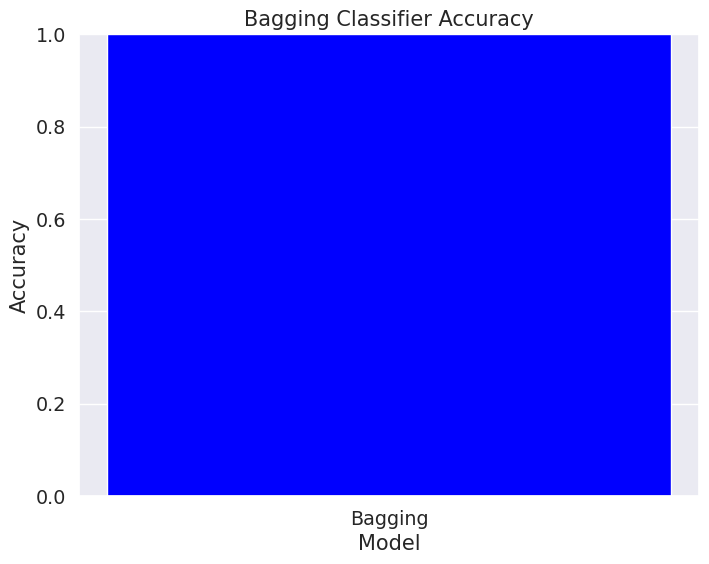

In [30]:
bagging()

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def boosting():
    # Building and fitting
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)
    boost = AdaBoostClassifier(base_estimator=clf, n_estimators=500)
    boost.fit(X_train, y_train)

    # make class predictions for the testing set
    y_pred_class = boost.predict(X_test)

    # Compute accuracy directly
    accuracy = accuracy_score(y_test, y_pred_class)

    # Data for final graph
    methodDict['Boosting'] = accuracy * 100

    # Plot the performance graph
    plt.figure(figsize=(8, 6))
    plt.bar(['Boosting'], [accuracy], color='green')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Boosting Classifier Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


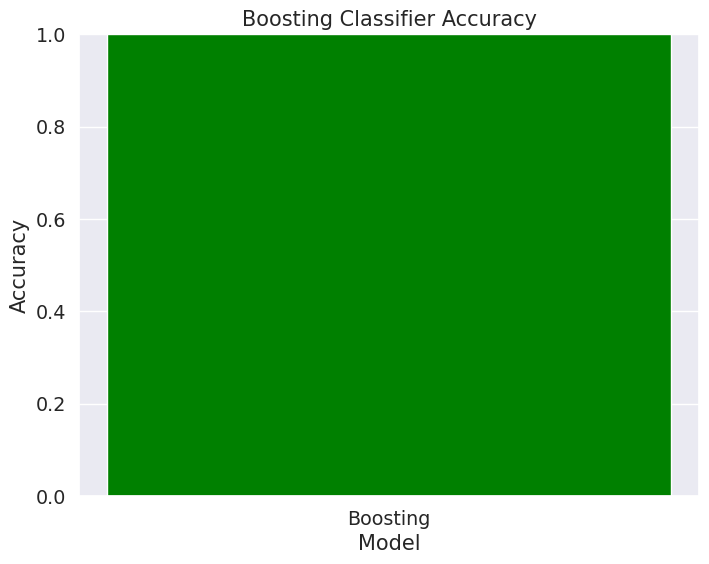

In [32]:
boosting()

In [33]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def stacking():
    # Building and fitting
    clf1 = ('knn', KNeighborsClassifier(n_neighbors=1))
    clf2 = ('rf', RandomForestClassifier(random_state=1))
    clf3 = ('gnb', GaussianNB())
    lr = LogisticRegression()
    stack = StackingClassifier(estimators=[clf1, clf2, clf3], final_estimator=lr)
    stack.fit(X_train, y_train)

    # make class predictions for the testing set
    y_pred_class = stack.predict(X_test)

    # Compute accuracy directly
    accuracy = accuracy_score(y_test, y_pred_class)

    # Data for final graph
    methodDict['Stacking'] = accuracy * 100

    # Plot the performance graph
    plt.figure(figsize=(8, 6))
    plt.bar(['Stacking'], [accuracy], color='blue')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Stacking Classifier Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

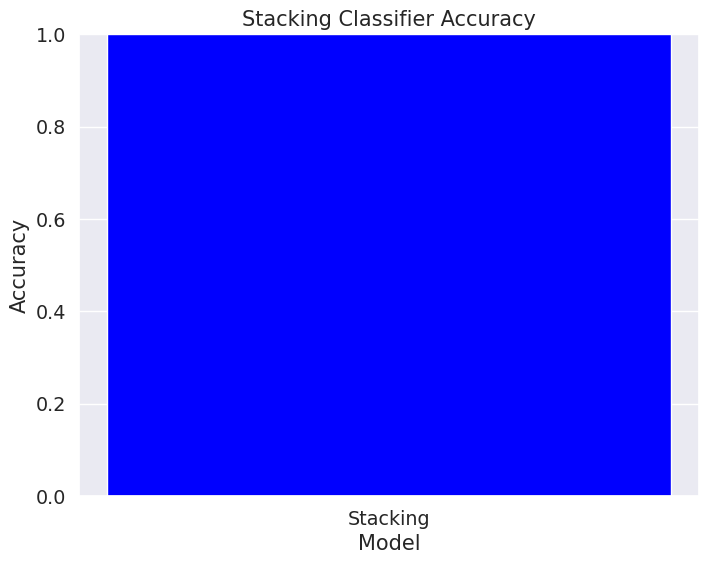

In [34]:
stacking()

In [35]:
%tensorflow_version 2.x
import tensorflow as tf
import argparse


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [36]:
print(tf.__version__)

2.15.0


In [37]:
batch_size = 100
train_steps = 1000

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle, repeat, and batch the examples.
    return dataset.shuffle(1000).repeat().batch(batch_size)

def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset

In [54]:
# Define TensorFlow feature columns
age = tf.feature_column.numeric_column("Age")
sex = tf.feature_column.numeric_column("Sex")
occupation = tf.feature_column.numeric_column("Occupation")
days_indoors = tf.feature_column.numeric_column("Days_Indoors")
growing_stress = tf.feature_column.numeric_column("Growing_Stress")
quarantine_frustrations = tf.feature_column.numeric_column("Quarantine_Frustrations")
changes_habits = tf.feature_column.numeric_column("Changes_Habits")  # Corrected column name
mental_health_history = tf.feature_column.numeric_column("Mental_Health_History")
weight_change = tf.feature_column.numeric_column("Weight_Change")
mood_swings = tf.feature_column.numeric_column("Mood_Swings")
coping_struggles = tf.feature_column.numeric_column("Coping_Struggles")
work_interest = tf.feature_column.numeric_column("Work_Interest")
social_weakness = tf.feature_column.numeric_column("Social_Weakness")

# Create a list of feature columns
feature_columns = [
    age, sex, occupation, days_indoors, growing_stress, quarantine_frustrations, changes_habits, mental_health_history, weight_change, mood_swings, coping_struggles, work_interest, social_weakness
]




In [63]:
# Build a DNN with 2 hidden layers and 10 nodes in each hidden layer.
model = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[10, 10],
    optimizer=tf.keras.optimizers.legacy.Adagrad(learning_rate=0.1),
    n_classes=3  # Specify the number of classes
)


In [64]:
model.train(input_fn=lambda:train_input_fn(X_train, y_train, batch_size), steps=train_steps)

Instructions for updating:
Use tf.keras instead.


In [65]:
# Evaluate the model.
eval_result = model.evaluate(
    input_fn=lambda:eval_input_fn(X_test, y_test, batch_size))

print('\nTest set accuracy: {accuracy:0.2f}\n'.format(**eval_result))

#Data for final graph
accuracy = eval_result['accuracy'] * 100
methodDict['Neural Network'] = accuracy

Instructions for updating:
Use tf.keras instead.



Test set accuracy: 1.00



In [66]:
predictions = list(model.predict(input_fn=lambda:eval_input_fn(X_train, y_train, batch_size=batch_size)))

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


In [67]:
# Generate predictions from the model
template = ('\nIndex: "{}", Prediction is "{}" ({:.1f}%), expected "{}"')

# Dictionary for predictions
col1 = []
col2 = []
col3 = []


for idx, input, p in zip(X_train.index, y_train, predictions):
    v  = p["class_ids"][0]
    class_id = p['class_ids'][0]
    probability = p['probabilities'][class_id] # Probability

    # Adding to dataframe
    col1.append(idx) # Index
    col2.append(v) # Prediction
    col3.append(input) # Expecter


    #print(template.format(idx, v, 100 * probability, input))


results = pd.DataFrame({'index':col1, 'prediction':col2, 'expected':col3})
results.head()

,index,prediction,expected
0,408,2,2
1,513,1,1
2,306,2,2
3,109,0,0
4,263,1,1


In [68]:
def plotSuccess():
    s = pd.Series(methodDict)
    s = s.sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    #Colors
    ax = s.plot(kind='bar')
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.ylim([70.0, 90.0])
    plt.xlabel('Method')
    plt.ylabel('Percentage')
    plt.title('Success of methods')

    plt.show()

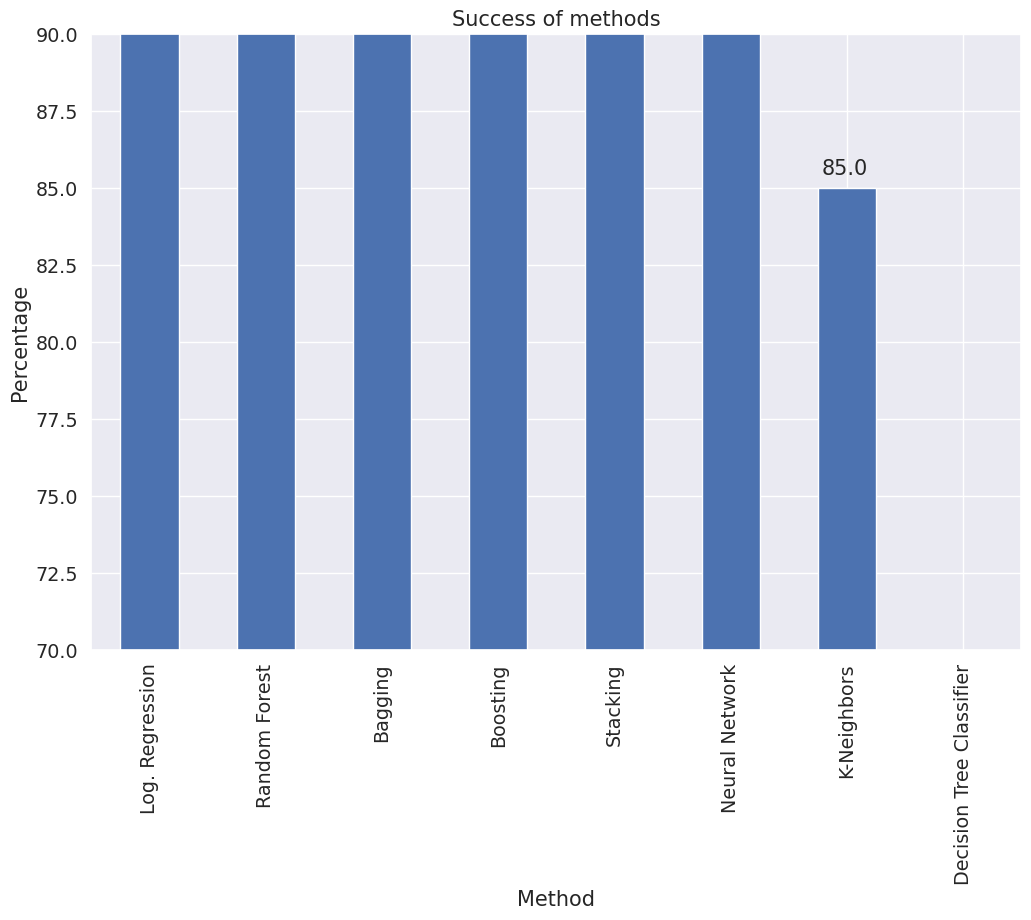

In [69]:
plotSuccess()

In [70]:
# Generate predictions with the best method
clf = AdaBoostClassifier()
clf.fit(X, y)
dfTestPredictions = clf.predict(X_test)

# Write predictions to csv file
# We don't have any significative field so we save the index
results = pd.DataFrame({'Index': X_test.index, 'Treatment': dfTestPredictions})
# Save to file
# This file will be visible after publishing in the output section
results.to_csv('results.csv', index=False)
results.head()

,Index,Treatment
0,399,0
1,533,0
2,345,2
3,40,1
4,641,0


In [71]:
# We don't have any significative field so we save the index
results = pd.DataFrame({'Index': X_test.index, 'Treatment': dfTestPredictions})
results

,Index,Treatment
0,399,0
1,533,0
2,345,2
3,40,1
4,641,0
...,...,...
235,35,2
236,81,2
237,159,1
238,441,1
